<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Sayeh Jarollahi
### Student Number : 98101339
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [ ]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,) , (0.3081,), inplace=False)
])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [ ]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [ ]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [ ]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.model1 = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2),
        )
        self.model2 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
          nn.ReLU()
        )
        self.model3 = nn.Sequential(
          nn.MaxPool2d(2),
          nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
          nn.ReLU()
        )
        self.model4 = nn.Sequential(
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
          nn.ReLU()
        )
        self.model5 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(), 
            nn.Linear(64, 10)
        )
        self.s = nn.Softmax(dim=1)
    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(out1)
        x = out1 + out2
        out1 = self.model3(x)
        out2 = self.model4(out1)
        x = out1 + out2
        return self.s(self.model5(x))


# Train Model (30 Points)

In [ ]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
learning_rate = 0.001
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20
train_loss_arr, val_loss_arr = [], []
train_acc_arr, val_acc_arr = [], []
for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    val_acc , train_acc = 0, 0
    model.train()
    for images, labels in train_loader: 
        images, labels = images.to(device), labels.to(device) 
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
        train_acc += torch.sum(torch.max(outputs, axis=1)[1] == labels).item()
    
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device) 
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_acc += torch.sum(torch.max(outputs, axis=1)[1] == labels).item()

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    train_acc /= len(train_loader.dataset)
    val_acc /= len(val_loader.dataset)
    val_acc_arr.append(val_acc)
    train_acc_arr.append(train_acc)


    print(f"[Epoch {epoch}]\t"
            f"Train Loss: {train_loss:.4f}\t"
            f"Validation Loss: {val_loss:.4f}\t"
            f"Train Acc: {train_acc:.4f}\t"
            f"Validation Acc: {val_acc:.4f}"
            )

[Epoch 0]	Train Loss: 1.7817	Validation Loss: 1.7188	Train Acc: 0.6784	Validation Acc: 0.7417
[Epoch 1]	Train Loss: 1.6468	Validation Loss: 1.5245	Train Acc: 0.8140	Validation Acc: 0.9372
[Epoch 2]	Train Loss: 1.5099	Validation Loss: 1.4936	Train Acc: 0.9517	Validation Acc: 0.9672
[Epoch 3]	Train Loss: 1.4971	Validation Loss: 1.4959	Train Acc: 0.9641	Validation Acc: 0.9649
[Epoch 4]	Train Loss: 1.4915	Validation Loss: 1.5023	Train Acc: 0.9695	Validation Acc: 0.9589
[Epoch 5]	Train Loss: 1.4899	Validation Loss: 1.4895	Train Acc: 0.9710	Validation Acc: 0.9717
[Epoch 6]	Train Loss: 1.4866	Validation Loss: 1.4864	Train Acc: 0.9744	Validation Acc: 0.9749
[Epoch 7]	Train Loss: 1.4854	Validation Loss: 1.4856	Train Acc: 0.9759	Validation Acc: 0.9759
[Epoch 8]	Train Loss: 1.4845	Validation Loss: 1.4891	Train Acc: 0.9766	Validation Acc: 0.9720
[Epoch 9]	Train Loss: 1.4865	Validation Loss: 1.4924	Train Acc: 0.9745	Validation Acc: 0.9689
[Epoch 10]	Train Loss: 1.4879	Validation Loss: 1.4862	Train 

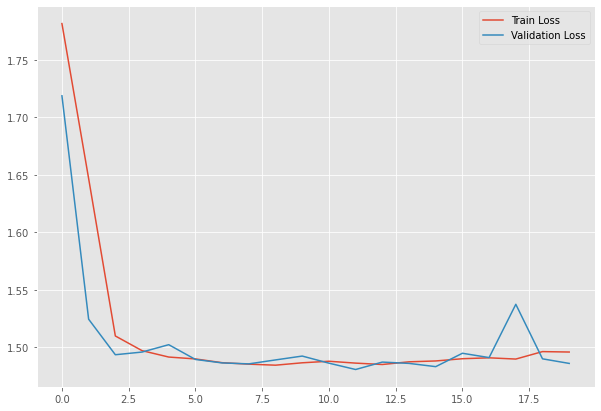

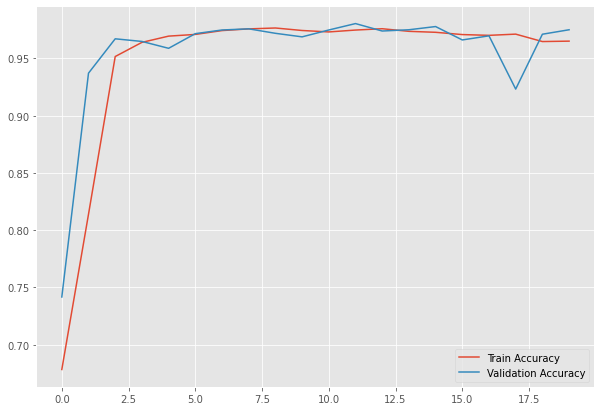

In [ ]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.figure(figsize=(10, 7))
plt.plot(train_loss_arr)
plt.plot(val_loss_arr)
plt.legend(["Train Loss", "Validation Loss"]);
plt.figure(figsize=(10, 7))
plt.plot(train_acc_arr)
plt.plot(val_acc_arr)
plt.legend(["Train Accuracy", "Validation Accuracy"]);

# Test Model (20 Points)

10000
test loss: 1.4836317182540895  test accuracy: 0.9774


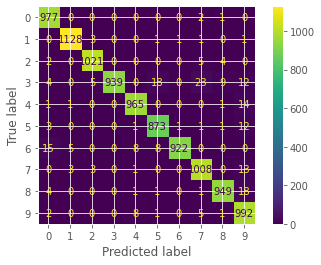

[[ 977    0    0    0    0    0    0    2    1    0]
 [   0 1128    3    0    0    1    1    1    0    1]
 [   2    0 1021    0    0    0    0    5    4    0]
 [   4    0    5  939    0   18    0   23    9   12]
 [   1    1    0    0  965    0    0    0    1   14]
 [   3    0    0    0    1  873    1    1    1   12]
 [  15    5    0    0    8    8  922    0    0    0]
 [   0    3    3    0    1    0    0 1008    0   13]
 [   4    0    0    0    1    1    0    1  949   18]
 [   2    0    0    0    8    1    0    5    1  992]]


In [ ]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))
y_pred, y_true = [], []

with torch.no_grad():
    test_loss = 0
    test_acc = .0
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        test_acc += (outputs.max(axis=1)[1] == labels).sum().item()
        y_pred.extend(outputs.max(axis=1)[1].tolist())
        y_true.extend(labels.tolist())

test_loss /= len(test_loader.dataset)
test_acc /= len(test_loader.dataset)
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
print('test loss:', test_loss, ' test accuracy:',test_acc)
cmd.plot()
plt.show()
print(cm)